In [ ]:
import os
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm
from collections import defaultdict

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ishadss/electrical-grid-stability-simulated-data-data-set")

print("Path to dataset files:", path)

100%|██████████| 1.06M/1.06M [00:00<00:00, 1.14MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ishadss/electrical-grid-stability-simulated-data-data-set/versions/1


In [ ]:
!ls /root/.cache/kagglehub/datasets/ishadss/electrical-grid-stability-simulated-data-data-set/versions/1

Data_for_UCI_named.csv


In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


### Данные

In [ ]:
df = pd.read_csv(f'{path}/Data_for_UCI_named.csv', sep=',')
df['stabf'] = df['stabf'].map({'unstable': 0, 'stable': 1})
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


In [ ]:
df.shape

(10000, 14)

In [ ]:
X, y = df.drop(['stabf', 'stab'], axis=1), df['stabf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((6000, 12), (2000, 12), (2000, 12))

### Обертки для данных

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X.values)
        self.y = torch.from_numpy(y.values).reshape(-1, 1).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Модель

In [ ]:
class BestTorchModel(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

### Train/eval loops

In [ ]:
def train_model(model, num_epochs=100, eval_freq=10):
  train_loss_history, eval_loss_history = [], []
  train_f1_history, eval_f1_history = [], []
  global_step = 0

  model.train()
  for epoch in tqdm(range(num_epochs)):
      for batch_X, target in train_dataloader:
        optimizer.zero_grad()
        log_probs = model(batch_X.to(device))
        loss = loss_function(log_probs, target.to(device))
        loss.backward()
        optimizer.step()

        preds = (log_probs >= 0.5).int().cpu().tolist()
        f1 = f1_score(preds, target.cpu().numpy().tolist())

        train_loss_history.append((global_step, loss.item()))
        train_f1_history.append((global_step, f1))

        if global_step % eval_freq == 0:
              val_loss, val_f1 = evaluate(model)
              eval_loss_history.append((global_step, val_loss))
              eval_f1_history.append((global_step, val_f1))
              model.train()

        if global_step % 250 == 0:
              clear_output(True)

              plt.figure(figsize=(15, 5))

              plt.subplot(121)
              plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
              if len(eval_loss_history):
                  plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
              plt.legend()

              plt.subplot(122)
              plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
              if len(eval_f1_history):
                  plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
              plt.legend()
              plt.show()
        global_step += 1

  return model

In [ ]:
@torch.no_grad()
def evaluate(model, mode='eval'):
    model.eval()

    dataloader = val_dataloader if mode == 'eval' else test_dataloader

    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for batch_X, target in dataloader:
      log_probs = model(batch_X.to(device))
      loss = loss_function(log_probs, target.to(device))
      num = log_probs.shape[0]
      loss_epoch += loss.item() * num
      num_epoch += num

      preds_list += (log_probs >= 0.5).int().cpu().tolist()
      targets_list += target.cpu().numpy().tolist()

    f1 = f1_score(preds_list, targets_list)

    return loss_epoch / num_epoch, f1

### Первая модель

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = BestTorchModel(1, 12, 12, 3)
model.to(device)

BestTorchModel(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=1, bias=True)
  )
)

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

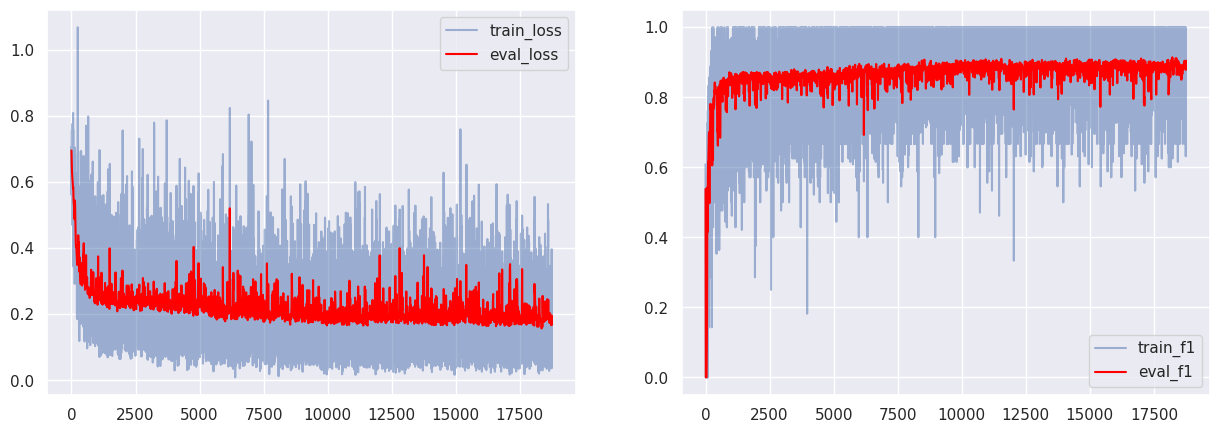

In [ ]:
model = train_model(model, num_epochs=100)

In [ ]:
evaluate(model, mode='test')

(0.2933132297992706, 0.83775447254781)

### Слои нормализации - начало

#### Covariate Shift

Ковариантный сдвиг — явление, когда признаки тренировочной и тестовой выборок **распределены по-разному**

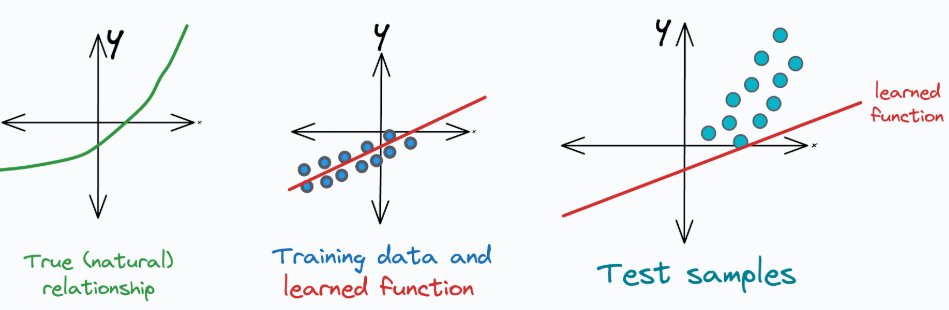

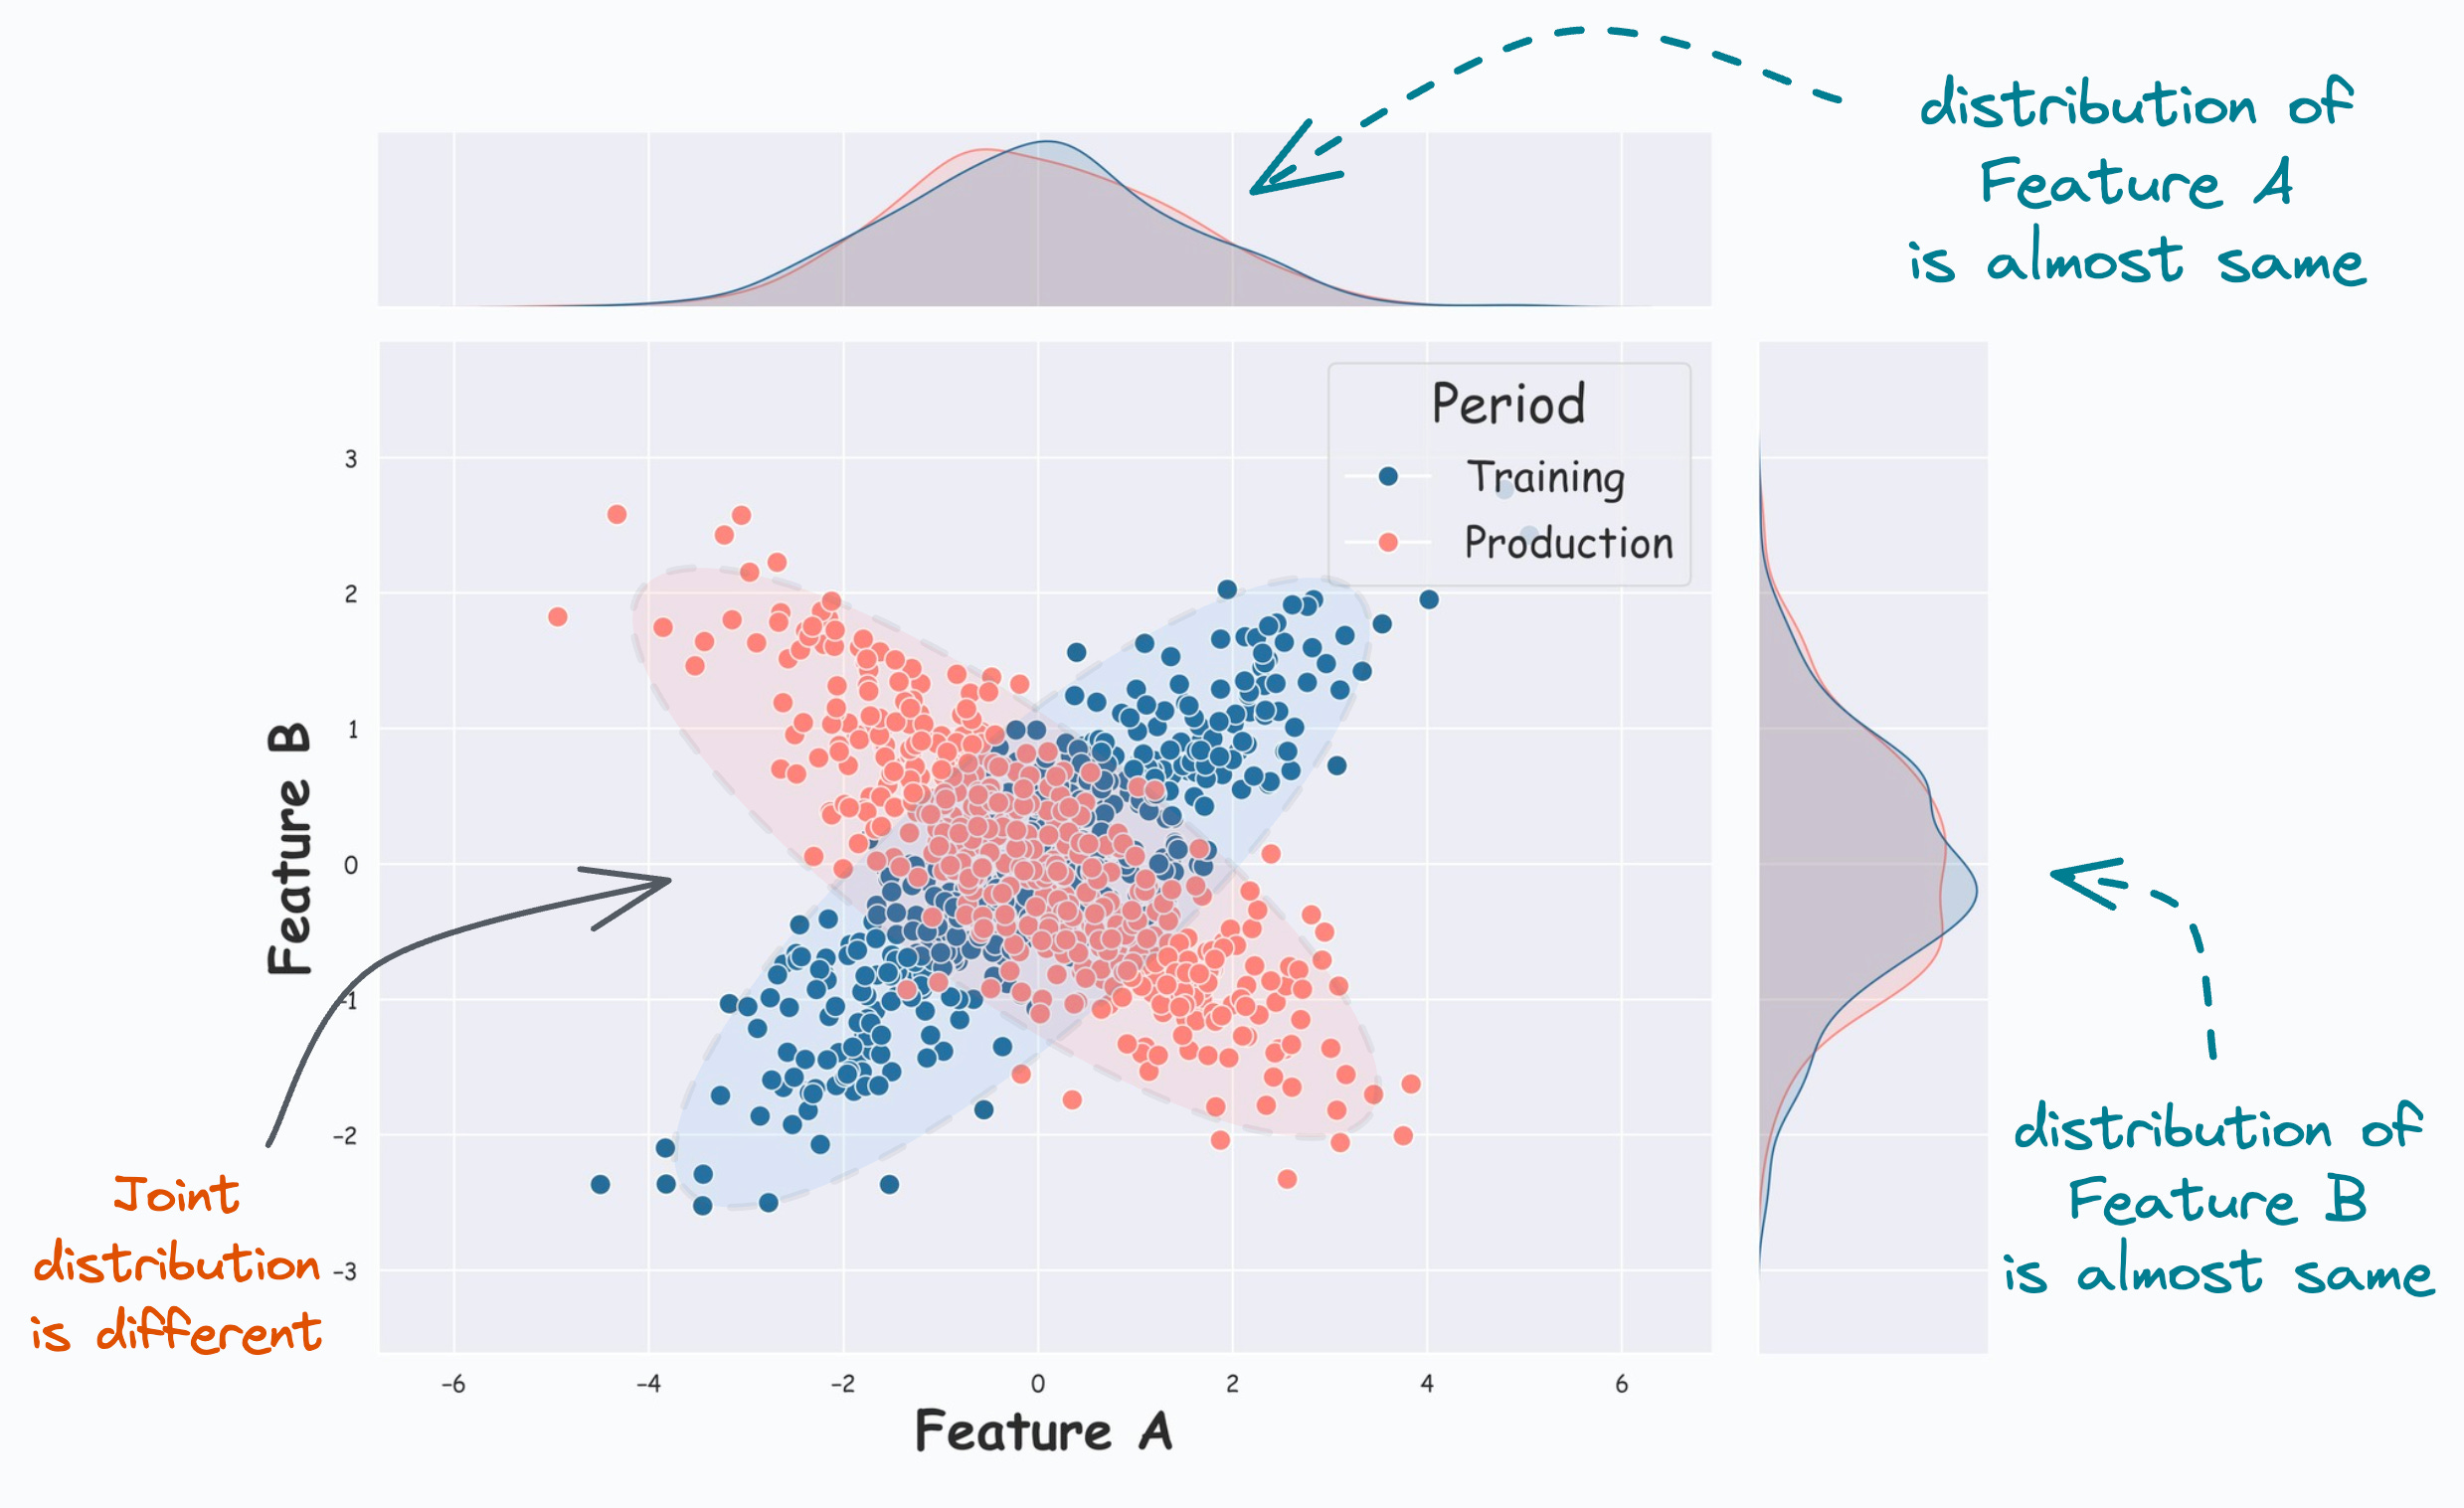

#### Internal covariate shift



В статье [Batch Normalization: Accelerating Deep Network Training by
Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf) авторы предположили, что похожее явление имеет место внутри нейросети, назвав его **internal covariate shift**.

**Internal covariate shift** — это изменение распределения выхода слоя активации из-за изменения обучаемых параметров во время обучения.



<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/internal_covariate_shift_example.png" width="1000">

Пусть у нас $k$-ый нейрон $i$-го слоя переводит выход $i$−1 слоя с распределением <font color='#F9B041'>$f^{(j)}_{i-1}(x)$</font> в новое пространство с распределением <font color='#5D5DA6'>$f^{(k)}_{i}(x)$</font>.

При обучении:
- нейросеть делает предсказание,
- считается значение функции потерь,
- делается обратное распространение ошибки,
- обновляются веса.


После обновления весов $k$-ый нейрон $i$-го слоя будет переводить выходы $i$−1 слоя <font color='#F9B041'>$f^{(j)}_{i-1}(x)$</font> в пространство с другим распределением <font color='#5D5DA6'>$f^{*(k)}_{i}(x)$</font>.

При этом $i$+1 слой учился работать со старым распределением  <font color='#5D5DA6'>$f^{(k)}_{i}(x)$</font>, и будет хуже обрабатывать <font color='#5D5DA6'>$f^{*(k)}_{i}(x)$</font>.

#### Плохой вариант борьбы с этим

Можно на каждом слое нормировать **каждый признак** (выход каждого нейрона), используя среднее и дисперсию по батчу:

$$ \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$




Проблема в том, что таким образом мы можем попасть в область линейной составляющей нашей функции. Например, в случае сигмоиды:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/domain_of_linear_of_sigmoid_function.png" width="500"></center>

Получаем набор линейных слоев фактически без функций активации, следовательно, все вырождается в однослойную сеть. Не то, что нам надо.

#### Batch Normalization

Надо дать нейронной сети **возможность перемещать распределение выходов** слоя из области $0$ и самой **подбирать дисперсию**. Для этой цели используется **батч-нормализация** (*batch normalization*), которая вводит в нейронную сеть дополнительную операцию между соседними скрытыми слоями.

Она состоит из **нормализации** входящих (в слой батч-нормализации) значений, полученных от скрытого слоя, **масштабирования** и **сдвига** с применением двух новых параметров и передачи полученных значений на вход следующему скрытому слою.

 <center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnormalization.png" width="400"> </center>

Параметры, используемые в батч-нормализации ($\gamma$ — параметр, отвечающий за **сжатие**, и $\beta$ — параметр, отвечающий за **сдвиг**), являются **обучаемыми параметрами** (наподобие весов и смещений скрытых слоев).

Помимо обучаемых параметров $\gamma$ и $\beta$ в слое батч-нормализации существуют также необучаемые параметры: **скользящее среднее матожидания** (_Mean Moving Average_) и **скользящее среднее дисперсий** (_Variance Moving Average_), служащие для сохранения состояния слоя батч-нормализации.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnorm_layer_parameters.png" width="900"></center>

Параметры $\gamma$, $\beta$, а также оба скользящих средних вычисляются для каждого слоя батч-нормализации отдельно и являются векторами с **длиной, равной количеству входящих признаков.**

В процессе обучения мы подаем в нейронную сеть **по одному мини-батчу за раз**. Процедуру обработки значений одного признака $x^{(k)}$ (фиолетовая колонка на изображении ниже), который для краткости мы будем обозначать $x$,  из одного мини-батча $ B = \{x_{1},\ldots, x_{m}\} $ можно представить следующим образом:



<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batch_normalization_compute_moving_average.png" width="1000"></center>

Шаг **масштабирования** Gamma ($γ$) и шаг **сдвига** Beta ($β$) являются главным новшеством батч-нормализации, поскольку, в отличие от предыдущего рассмотренного примера, нормированные значения больше не обязаны иметь среднее, равное $0$, и единичную дисперсию. Батч-нормализация позволяет сдвигать среднее нормированных значений и масштабировать дисперсию. Фактически теперь **нейросеть даже может отменить нормализацию входных данных, если считает ее ненужной.**

Для наглядности проиллюстрируем размерности промежуточных переменных на следующем изображении:

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batch_normalization_compute_moving_average_scheme.png" width="1000">

После прямого прохода параметры $\gamma$ и $\beta$ **обновляются через обратное распространение ошибки** так же, как и веса скрытых слоев.

##### Скользящее среднее

Выше мы обсуждали то, что в процессе обучения слой батч-нормализации рассчитывает значение **среднего и дисперсии** каждого признака в соответствующем **мини-батче**. Предположим, что нам нужно сделать предсказание на одном объекте. Во время предсказания батч у нас уже отсутствует. Откуда брать среднее и дисперсию?

Во время предсказания используется **скользящее среднее**, которое было **рассчитано и сохранено в процессе обучения**.

$$\large \mu_{mov_{B}} = (1-\alpha)\mu_{mov_{B-1}}+\alpha\mu_{B} $$

$$\large \sigma_{mov_{B}} = (1-\alpha)\sigma_{mov_{B-1}}+\alpha\sigma_{B} $$

Обычно используется параметр $\alpha = 0.1$

Для перевода модели из режима обучения в режим тестирования и обратно в PyTorch используются `model.train()` и `model.eval()`.

$$
\begin{array}{c|c}
\large{\text{model.train()}}&\ \large{\text{model.eval()}}\\  \hline
\large{\text{Батч-нормализация использует статистику по батчу}}&\large{\text{Батч-нормализация использует скользящие средние}}\\
\large{\text{Cкользящие средние копятся}}
\end{array}
$$



Почему используется именно скользящее среднее, а не статистика всей обучающей выборки?

При таком подходе нам бы пришлось хранить средние всех признаков для всех батчей, пропущенных через нейросеть в ходе обучения. Это ужасно невыгодно по памяти. Вместо этого скользящее среднее выступает в качестве приближенной оценки среднего и дисперсии обучающего набора. В этом случае эффективность использования ресурсов увеличивается: нам нужно **хранить в памяти только одно число** — значение скользящего среднего, полученное на последнем шаге.

##### Кастомный BatchNorm

Наивная реализация BatchNorm

```python
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y
```



##### А что там в PyTorch?

[nn._BatchNorm](https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/batchnorm.py#L143)

[F.batch_norm](https://github.com/pytorch/pytorch/blob/main/torch/nn/functional.py#L2791)

[batch_norm_cpu_inference_contiguous](https://github.com/pytorch/pytorch/blob/420b37f3c67950ed93cd8aa7a12e673fcfc5567b/aten/src/ATen/native/Normalization.cpp#L62)

[cudnn_batch_norm](https://github.com/pytorch/pytorch/blob/7aae51cdedcbf0df5a7a8bf50a947237ac4b3ee8/aten/src/ATen/native/cudnn/BatchNorm.cpp#L52-L143)

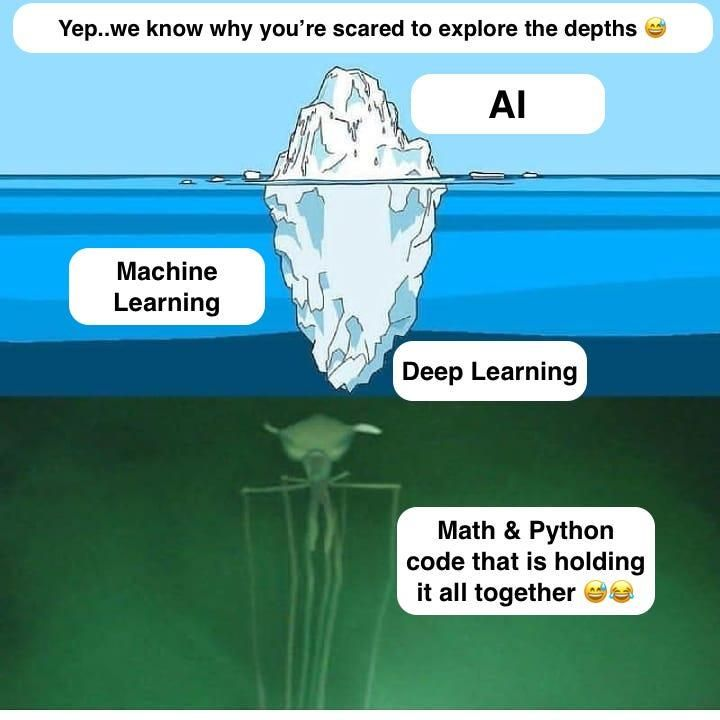

##### Вторая модель - BN

Для полносвязных слоев - [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)

In [ ]:
class BestTorchModel_BN(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_BN, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

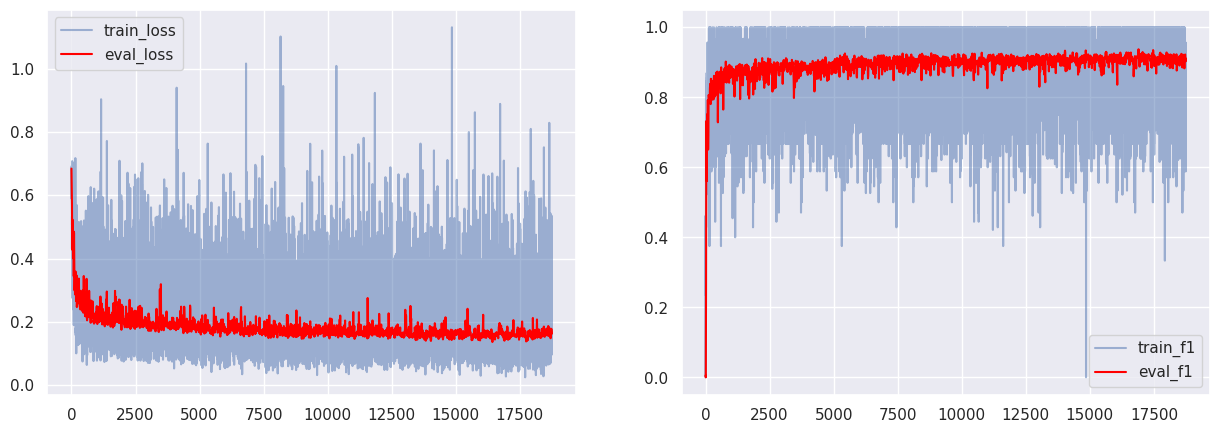

In [ ]:
model = BestTorchModel_BN(1, 12, 12, 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

model = train_model(model, num_epochs=100)

In [ ]:
evaluate(model, mode='test')

(0.16549215012788773, 0.9040902679830748)

И еще попробуем 120 эпох (потом пригодится)

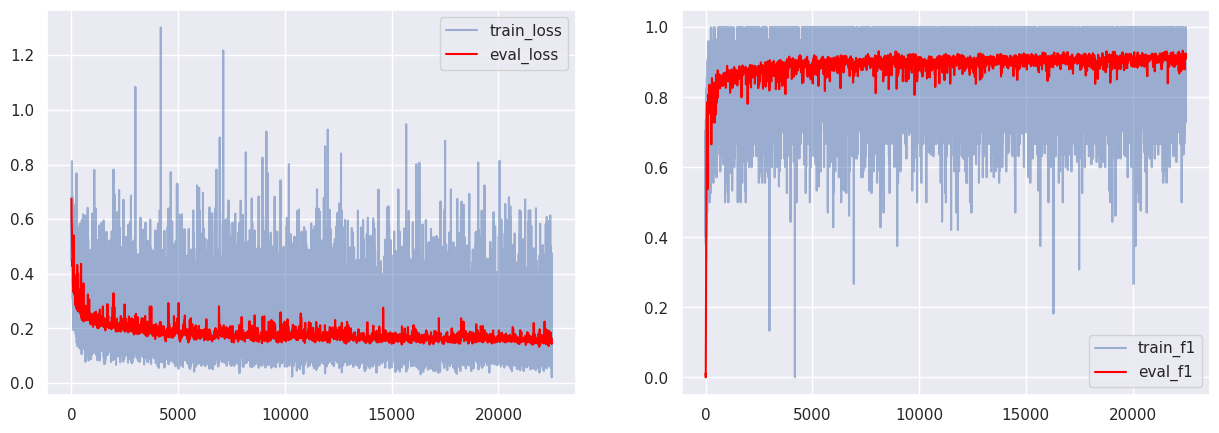

In [ ]:
model = BestTorchModel_BN(1, 12, 12, 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

model = train_model(model, num_epochs=120)

In [ ]:
evaluate(model, mode='test')

(0.15375732484459878, 0.9098774333093006)

In [ ]:
model

BestTorchModel_BN(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=12, bias=True)
    (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=12, out_features=1, bias=True)
  )
)

##### Сглаживающий эффект Batch Normalization

Batch Normalization была разработана на идее необходимости коррекции Internal covariate shift. В 2019 году вышла статья [How Does Batch Normalization Help Optimization?](https://arxiv.org/pdf/1805.11604.pdf), которая показала, что влияние коррекции Internal covariate shift на качество обучения не так велико, как считали авторы Batch Normalization.

Другим интересным эффектом Batch Normalization оказалось **сглаживание ландшафта** функции потерь. Batch Normalization улучшает гладкость пространства решений и облегчает поиск в нем минимума. Именно благодаря сглаживанию ландшафта Batch Normalization справляется с затуханием и взрывом градиента.


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnorm_helps_find_minimum_of_function.jpg" width="900"></center>

##### Советы по использованию Batch Normalization

Стоит помнить, что с батч-нормализацией:

* Чем **меньше размер батча в обучении**, тем **хуже** будет работать Batch Normalization.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnorm_batch_size.png" width="500"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1803.08494.pdf">Group Normalization</a></em></center>





* В слое, после которого поставили Batch Normalization, можно **убрать bias** (параметр $\beta$ в Batch Normalization берет эту роль на себя).

* Другое расписание **learning rate: большее значение** в начале обучения и быстрое уменьшение в процессе обучения.

* Важно перемешивать объекты (составлять новые батчи) между эпохами. Единицей обучения параметров $\beta$ и $\gamma$ являются батчи. Если их не перемешивать, то из 6400 объектов в тренировочном датасете получим лишь 100 объектов (при условии, что в батче 64 объекта) для обучения $\beta$ и $\gamma$. Данное требование учитывается автоматически при использовании стохастического градиентного спуска в качестве алгоритма оптимизации параметров сети.

##### Ставить Batch Normalization до или после активации?



###### До

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnormalization_before_activation.png" width="350"></center>

* **Рекомендуется авторами статьи, где предложили Batch Normalization**.
* Для **сигмоиды** BN, поставленная после активации, **не решает проблем** сигмоиды.
* Во многих сверточных архитектурах, например, ResNet и MobileNetV2, Batch Normalization ставится именно так.

###### После

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnormalization_after_activation.png" width="350"></center>

* **Аргументация авторов статьи не до конца обоснована**.
* Обычно **сигмоиду не используют** в современных нейронных сетях.
* Для популярной **ReLU BN**, поставленная до активации, может приводить в определённых случаях к “умирающей **ReLU**”, когда большая часть ее входов меньше $0$, и поэтому через них градиент не проходит.

**BN — before or after ReLU?**

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/batchnormalization_before_or_after_relu.png" width="500">

<em>Source: <a href="https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md">BN experiments</a></em></center>

**Вывод:** В общем случае стоит располагать слой BN перед активацией, но с этим можно экспериментировать.

### Регуляризация

Второй способ улучшения сходимости нейросетей и борьбы с переобучением — введение регуляризации. Ее можно вводить несколькими способами.

#### L1, L2 регуляризации

Мы уже разбирали самый простой способ — добавление штрафа к весам в функцию потерь. На сходимость нейросети это, правда, влияет слабо.

$$ \text{Loss_reg} = \text{loss} + \lambda \cdot \text{reg}$$

$$ \text{reg}_{L1} = \lambda \sum |w_i| $$

$$ \text{reg}_{L2} = \lambda \sum w_i^2 $$

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/loss_landscape_with_regularization.gif" width="800"></center>

<center><em>Source: <a href="https://people.eecs.berkeley.edu/~jrs/189/">Introduction to Machine Learning
</a></em></center>


Иногда уже этого хватает, чтобы решить все проблемы. Напомним, что **L2** Loss приводит к большому числу маленьких ненулевых весов в сети, а **L1** Loss — к маленькому числу ненулевых весов (разреженной нейросети).

#### Dropout

Одним из распространенных именно в нейросетях методом регуляризации является **Dropout**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/dropout.png" width="700"></center>

Состоит этот метод в следующем:

1. Во время обучения мы с вероятностью `p` **зануляем выход нейронов** слоя (например, `p=0.5`).
2. Зануленные нейроны не участвуют в данном `forward`, и поэтому градиент к ним при `backward` не идет.
3. Сила регуляризации определяется вероятностью `p`: чем она больше, тем сильнее регуляризация.

#### Мотивация Dropout

##### Борьба с коадаптацией

Одной из  проблем при работе с глубокими сетями является **совместная адаптация нейронов**. Если все весовые коэффициенты обучаются вместе, некоторые соединения будут иметь больше возможностей прогнозирования, чем другие.

Часть нейронов делает основную работу — предсказывает, а остальные могут вообще не вносить никакого вклада в итоговое предсказание. Или же другая картина: один нейрон делает неверное предсказание, другие его исправляют, и в итоге первый нейрон свои ошибки не исправляет.

Можно попробовать понять, как это работает, через аналогию — конвейер по сборке машины: основную часть работы может исполнять небольшое количество работников. Другие работники могут лениться и передавать деталь, которая к ним поступила, без изменений или откручивать только что добавленные части. Если мы исключим “эффективных работников”, результат станет удручающим.

Это явление называется **коадаптацией**. Его нельзя было предотвратить с помощью традиционной регуляризации, такой как L1 или L2. А вот Dropout с этим хорошо борется.

Отключая хорошо обученные нейроны, мы заставляем плохо обученные нейроны учиться. Отключая нейроны, которые исправляют ошибки других нейронов, мы заставляем ошибающиеся нейроны исправлять ошибки.

Dropout гарантирует, что выучиваемые индивидуальными нейронами функции хорошо работают со случайно выбранными подмножествами функций, выученных другими нейронами, улучшая обобщающую способность нейронов.

На следующем рисунке, извлеченном из [статьи про Dropout](https://jmlr.org/papers/v15/srivastava14a.html), мы находим сравнение признаков, изученных в наборе данных MNIST нейросетью с одним скрытым слоем в автоэнкодере, имеющем 256 признаков после ReLU без Dropout (слева), и признаков, изученных той же структурой с использованием Dropout в ее скрытом слое с `p=0.5` (справа).

Первый показывает неструктурированные, беспорядочные паттерны, которые невозможно интерпретировать. Второй явно демонстрирует целенаправленное распределение весов, которое обнаруживает штрихи, края и пятна самостоятельно, нарушая их взаимозависимость с другими нейронами для выполнения этой работы.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/compare_weights_with_dropout_and_without_dropout.png" width="600"></center>

<center><em>Source: <a href="https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf">Dropout: A Simple Way to Prevent Neural Networks from
Overfitting</a></em></center>

##### Dropout как регуляризация

Фактически Dropout штрафует слишком сложные, неустойчивые решения. Добавляя в нейросеть Dropout, мы сообщаем ей, что решение, которое мы ожидаем, должно быть устойчиво к шуму.

##### Dropout как ансамбль

Можно рассматривать Dropout как **ансамбль нейросетей** со схожими параметрами, которые мы учим одновременно вместо того, чтобы учить каждую в отдельности, а затем результат их предсказания усредняем, [выключая Dropout в режиме eval](https://habr.com/ru/companies/wunderfund/articles/330814/).

Таким образом возникает аналогия со случайным лесом: каждая из наших нейросетей легко выучивает выборку и переобучается — имеет низкий bias, но высокий variance. При этом, за счет временного отключения активаций, каждая нейросеть видит не все объекты, а только часть. Усредняя все эти предсказания, мы уменьшаем variance.

##### Dropout помогает бороться с переобучением

Dropout, в силу указанного выше, может хорошо помогать бороться с переобучением.

Например, в случае линейных слоев:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/dropout_solve_overfitting_problem_in_mlp_networks.png" width="500">

<em>Source: <a href="https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/">Tutorial: Dropout as Regularization and Bayesian Approximation</a></em></center>

#### Кастомный Dropout

Напишем "наивную" реализацию модуля Dropout.


```python
class BadDropout(nn.Module):
    def __init__(self, p: float=0.5):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError(
                f"Dropout probability has to be between 0 and 1, but got {p}"
            )
        self.p = p

    def forward(self, x):
        if self.training:
            keep = torch.rand(x.size()) > self.p
            if x.is_cuda:
                keep = keep.to(device)
            return x * keep
        # In test time, expectation is calculated
        return x * (1 - self.p) #
```



Приведенная реализация неоптимальна, так как в режиме инференса (когда `training = False`) функция `forward` совершает дополнительное умножение. Одним из приоритетов при создании модели является скорость работы в режиме инференса. Поэтому по возможности все "лишние" операции выполняют только в режиме обучения. В данном случае можно целиком убрать коэффициент нормировки из режима инференса, перенеся его в режим обучения в знаменатель.

Дополнительным плюсом такого подхода является то, что при удалении модуля из архитектуры сети функция прогнозирования не изменится.


```python
class Dropout(nn.Module):
    def __init__(self, p: float=0.2):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError(
                f"Dropout probability has to be between 0 and 1, but got {p}"
            )
        self.p = p

    def forward(self, x):
        if self.training:
            keep = torch.rand(x.size()) > self.p
            if x.is_cuda:
                keep = keep.to(x)
            return x * keep / (1 - self.p)
        return x  # in test time, expectation is calculated intrinsically - we just not divide weights
```



##### А что там в PyTorch?


[nn.Dropout](https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/dropout.py#L35)

[F.dropout](https://github.com/pytorch/pytorch/blob/main/torch/_refs/nn/functional/__init__.py#L186)



#### Третья модель - Dropout

In [ ]:
class BestTorchModel_Dropout(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_Dropout, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.Dropout(p=0.1), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Dropout(p=0.1))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

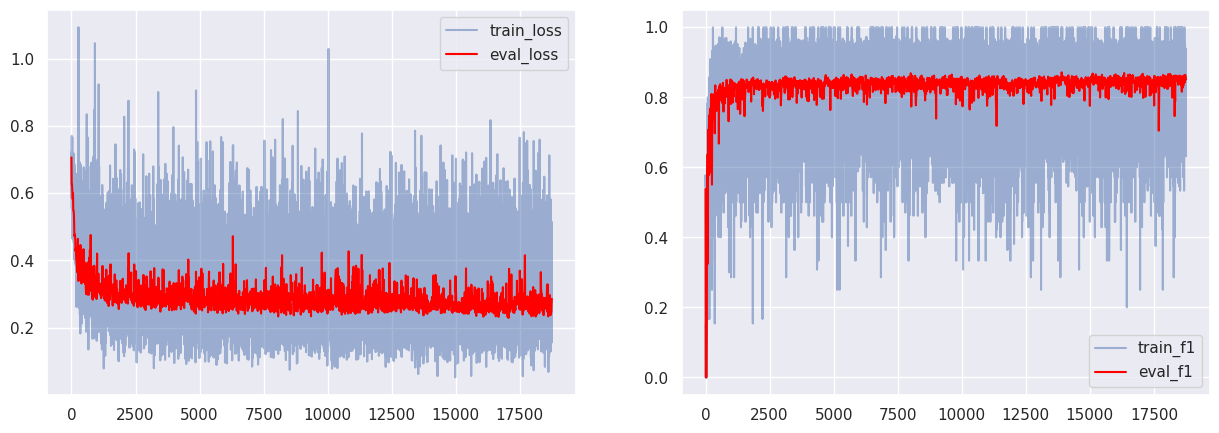

In [ ]:
model = BestTorchModel_Dropout(1, 12, 12, 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

model = train_model(model, num_epochs=100)

In [ ]:
evaluate(model, mode='test')

(0.2684421578645706, 0.8505586592178771)

Так как наша модель из-за Dropout ведет себя по-разному во время обучения и во время тестирования, мы должны прямо ей сообщать, обучается она сейчас или нет.

$$
\begin{array}{c|c}
\large{\text{model.train()}}&\ \large{\text{model.eval()}}\\  \hline
\large{\text{Активируются Dropout слои}}&\large{\text{Слои Dropout отключены}}\\
\large{\text{Выход части нейронов обнуляется, выходы нормируются}}&\large{\text{Все нейроны работают}}
\end{array}
$$



#### DropConnect

Если занулять не нейроны (активации), а случайные веса с вероятностью $p$, получится DropConnect.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/dropconnect.png" width="650"></center>

DropConnect похож на Dropout, поскольку он вводит динамическую разреженность в модель, но отличается тем, что разреженность зависит от весов *W*, а не от выходных векторов слоя. Другими словами, полностью связанный слой с DropConnect становится разреженно связанным слоем, в котором соединения выбираются случайным образом на этапе обучения.

В принципе, вариантов зануления чего-то в нейронной сети можно предложить великое множество, в разных ситуациях будут работать разные способы ([в этом списке](https://paperswithcode.com/methods/category/regularization) много Drop...).

### Batch Normalization до или после Dropout



#### После

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnormalization_after_dropout.png" width="400"></center>

* **Плохо**: В режиме обучения Dropout будет отключать (занулять) выходы слоя активации, из-за этого накопленные в режиме обучения значения скользящего среднего матожидания и дисперсии для вычисления Batch Normalization в режиме тестирования будут иметь **сдвиг** (не компенсируемый приведением слоя Dropout в режим `train()`), который приведет к нестабильной работе нейросети.


Подробно:
* [Understanding the Disharmony between Dropout and Batch Normalization by
Variance Shift (Li et al., 2018)](https://arxiv.org/pdf/1801.05134.pdf)
* [Understanding the Disharmony between Dropout and Batch Normalization](https://github.com/adelizer/kaggle-sandbox/blob/master/drafts/dropout_bn.ipynb)

##### Четвертая модель -  Dropout ▶ BN

In [ ]:
class BestTorchModel_DropoutBN(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_DropoutBN, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.Dropout(p=0.3), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Dropout(p=0.3))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

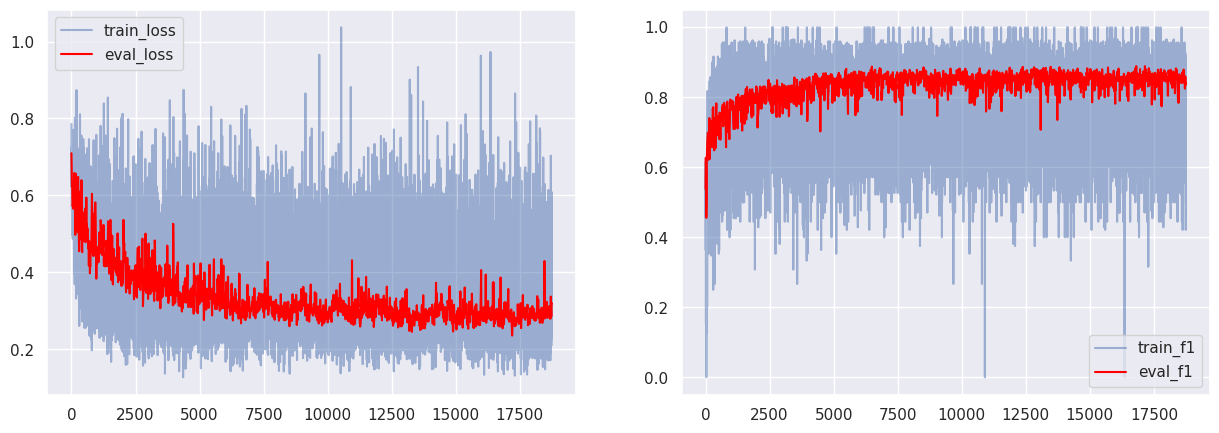

In [ ]:
model = BestTorchModel_DropoutBN(1, 12, 12, 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

model = train_model(model, num_epochs=100)

In [ ]:
evaluate(model, mode='test')

(0.2550848367214203, 0.8814814814814815)

#### До

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnormalization_before_dropout.png" width="400"></center>

* **Лучше**: Меньше влияние сдвига от Dropout на Batch Norm. Но если на предыдущих слоях есть Dropout, то значения все равно могут быть смещены.

##### Пятая модель - BN ▶ Dropout

In [ ]:
class BestTorchModel_BN_Dropout(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_BN_Dropout, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), nn.Dropout(p=0.3), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(p=0.3))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

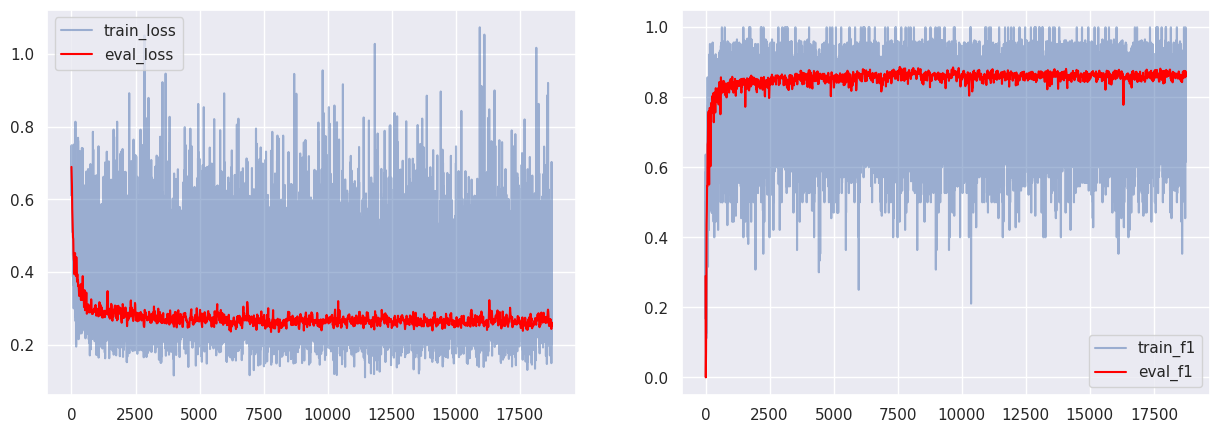

In [ ]:
model = BestTorchModel_BN_Dropout(1, 12, 12, 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

model = train_model(model, num_epochs=100)

In [ ]:
evaluate(model, mode='test')

(0.24975988483428954, 0.8540462427745664)

### Финальная модель

In [ ]:
class BestTorchModel_BN_Dropout_again(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BestTorchModel_BN_Dropout_again, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            if i == 0:
              layers.append(nn.Dropout(p=0.1))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

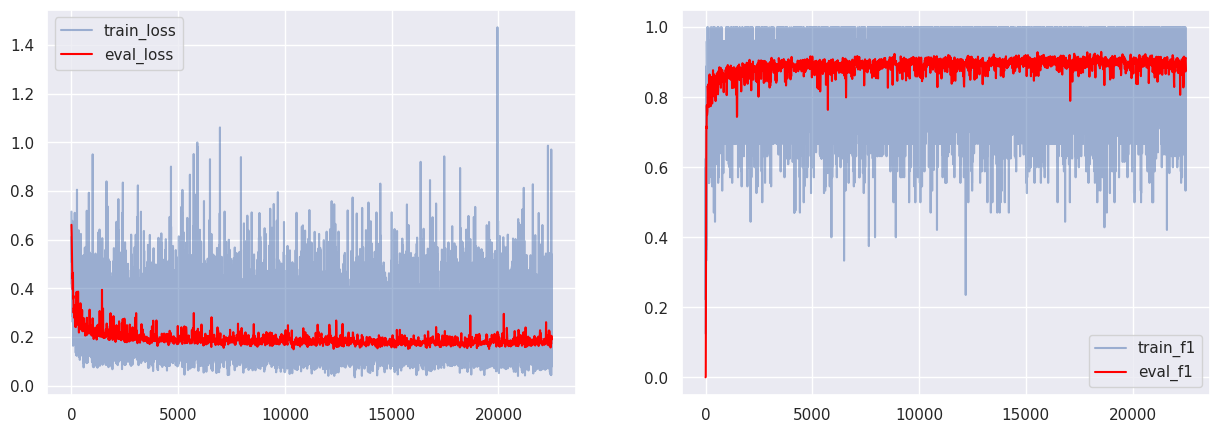

In [ ]:
model = BestTorchModel_BN_Dropout_again(1, 12, 12, 3)
model.to(device)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

model = train_model(model, num_epochs=120)

In [ ]:
evaluate(model, mode='test')

(0.16047008883953096, 0.9084354722422494)